In [1]:
import numpy as np
import math
from sys import maxsize
import matplotlib.pyplot as plt

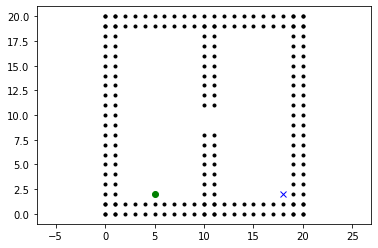

In [20]:
show_animation = False

class State:

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.state = "."
        self.t = "new"  # tag for state
        self.h = 0
        self.k = 0
        self.action = -1

    def cost(self, state):
        if self.state == "#" or state.state == "#":
            return maxsize

        return math.sqrt(math.pow((self.x - state.x), 2) +
                         math.pow((self.y - state.y), 2))

    def set_state(self, state):
        """
        .: new
        #: obstacle
        e: oparent of current state
        *: closed state
        s: current state
        """
        if state not in ["s", ".", "#", "e", "*"]:
            return
        self.state = state


class Map:

    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.map = self.init_map()

    def init_map(self):
        map_list = []
        for i in range(self.row):
            tmp = []
            for j in range(self.col):
                tmp.append(State(i, j))
            map_list.append(tmp)
        return map_list

    def get_neighbors(self, state):
        state_list = []
        for i in [1, 0, -1]:
            for j in [1, 0, -1]:
                if i == 0 and j == 0:
                    continue
                if state.x + i < 0 or state.x + i >= self.row:
                    continue
                if state.y + j < 0 or state.y + j >= self.col:
                    continue
                state_list.append(self.map[state.x + i][state.y + j])

        return state_list

    def set_obstacle(self, point_list):
        for x, y in point_list:
            if x < 0 or x >= self.row or y < 0 or y >= self.col:
                continue

            self.map[x][y].set_state("#")


class Dstar:
    def __init__(self, maps):
        self.map = maps
        self.open_list = set()
        self.action_dict = {(1,0):0, (-1,0):1, (0,1):2, (0,-1):3, (1,1):4, (1,-1):5, (-1,1):6, (-1,-1):7}

    def process_state(self):
        x = self.min_state()

        if x is None:
            return -1

        k_old = self.get_kmin()
        self.remove(x)
        state_list = self.map.get_neighbors(x)
        if k_old < x.h:
            for y in state_list:
                if y.h <= k_old and x.h > y.h + x.cost(y):
                    x.parent = y
                    x.h = y.h + x.cost(y)
        elif k_old == x.h:
            for y in state_list:
                if y.t == "new" or y.parent == x and y.h != x.h + x.cost(y) \
                        or y.parent != x and y.h > x.h + x.cost(y):
                    y.parent = x
                    self.insert(y, x.h + x.cost(y))
        else:
            for y in state_list:
                if y.t == "new" or y.parent == x and y.h != x.h + x.cost(y):
                    y.parent = x
                    self.insert(y, x.h + x.cost(y))
                else:
                    if y.parent != x and y.h > x.h + x.cost(y):
                        self.insert(y, x.h)
                    else:
                        if y.parent != x and x.h > y.h + x.cost(y) \
                                and y.t == "close" and y.h > k_old:
                            self.insert(y, y.h)
        return self.get_kmin()

    def min_state(self):
        if not self.open_list:
            return None
        min_state = min(self.open_list, key=lambda x: x.k)
        return min_state

    def get_kmin(self):
        if not self.open_list:
            return -1
        k_min = min([x.k for x in self.open_list])
        return k_min

    def insert(self, state, h_new):
        if state.t == "new":
            state.k = h_new
        elif state.t == "open":
            state.k = min(state.k, h_new)
        elif state.t == "close":
            state.k = min(state.h, h_new)
        state.h = h_new
        state.t = "open"
        self.open_list.add(state)

    def remove(self, state):
        if state.t == "open":
            state.t = "close"
        self.open_list.remove(state)

    def modify_cost(self, x):
        if x.t == "close":
            self.insert(x, x.parent.h + x.cost(x.parent))

    def run(self, start, end):
        pos_list = []
        action_list = []
        rx = []
        ry = []

        self.open_list.add(end)

        while True:
            self.process_state()
            if start.t == "close":
                break

        start.set_state("s")
        s = start
        s = s.parent
        s.set_state("e")
        tmp = start

        while tmp != end:
            tmp.set_state("*")
            rx.append(tmp.x)
            ry.append(tmp.y)
            pos_list.append([tmp.x,tmp.y])
#             if show_animation:
#                 plt.plot(rx, ry, "-r")
#                 plt.pause(0.01)
            if tmp.parent.state == "#":
                self.modify(tmp)
                continue
            tmp = tmp.parent
            
        tmp.set_state("e")            
        pos_list.append([end.x,end.y])
        pos_list = np.array(pos_list)

        for ind in range(len(pos_list) - 1):
            diff = pos_list[ind + 1] - pos_list[ind]
            action_list.append(self.action_dict[tuple(diff)])
        
        return pos_list, action_list

    def modify(self, state):
        self.modify_cost(state)
        while True:
            k_min = self.process_state()
            if k_min >= state.h:
                break


show_animation = True
m = Map(20, 20)
ox, oy = [], []

obstacle_list = [[0,21,0,2],[0,21,19,21],[19,21,0,21],
                 [0,2,0,21],[10,12,0,9],[10,12,11,20]]

for obs in obstacle_list:
    for i in range(obs[0], obs[1]):
        for j in range(obs[2], obs[3]):
            ox.append(i)
            oy.append(j)
        

m.set_obstacle([(i, j) for i, j in zip(ox, oy)])

start = [5, 2]
goal = [18, 2]
if show_animation:
    plt.plot(ox, oy, ".k")
    plt.plot(start[0], start[1], "og")
    plt.plot(goal[0], goal[1], "xb")
    plt.axis("equal")

start = m.map[start[0]][start[1]]
end = m.map[goal[0]][goal[1]]
dstar = Dstar(m)
pos_list, action_list = dstar.run(start, end)

# if show_animation:
#     plt.plot(rx, ry, "-r")
#     plt.show()



In [18]:
pos_list

array([[ 5,  2],
       [ 6,  3],
       [ 7,  4],
       [ 8,  5],
       [ 9,  6],
       [ 9,  7],
       [ 9,  8],
       [10,  9],
       [11,  9],
       [12,  8],
       [13,  7],
       [14,  6],
       [15,  5],
       [16,  4],
       [17,  3],
       [18,  2]])

In [19]:
action_list

[4, 4, 4, 4, 2, 2, 4, 0, 5, 5, 5, 5, 5, 5, 5]

In [4]:
goal

[18, 2]

2

In [113]:
ry

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9]

In [63]:
np.clip([2,5],3, 4)

array([3, 4])

In [23]:
obstacle_list = [[0, 21, 0, 1], [0, 21, 20, 21], [20, 21, 0, 21]]
len(obstacle_list)

3

In [51]:
rx

[11, -11, 8, -14, 5, -17, 2, -19, 0, 19, -3, 16, -4, 15]

In [50]:
N_prize = 5
assigned_agents_to_prizes = {i: [] for i in range(N_prize)}
dist = np.array([10,20,30,40,50])

assigned_agents_to_prizes[0].append(1)
assigned_agents_to_prizes[0].append(2)
assigned_agents_to_prizes[0].append(3)
assigned_agents_to_prizes[1].append(5)
assigned_agents_to_prizes[2].append(4)
assigned_agents_to_prizes[1].append(7)

lst = np.array([len(assigned_agents_to_prizes[abc]) for abc in assigned_agents_to_prizes]) + 1
rst = lst * dist
rst

array([40, 60, 60, 40, 50])

In [51]:
np.argmin(rst)

0

In [3]:
np.random.choice(range(5,16))

6

In [5]:
for i in range(5,16):
    print (i)

5
6
7
8
9
10
11
12
13
14
15


In [6]:
a = np.chararray((20,20))
a[:] = '.'

In [8]:
np.array(['' for i in range(5)] for j in range(5))

array(<generator object <genexpr> at 0x00000266D546C4C8>, dtype=object)

In [11]:
np.array(['' for _ in range(5)]*5).reshape(5,5)

array([['', '', '', '', ''],
       ['', '', '', '', ''],
       ['', '', '', '', ''],
       ['', '', '', '', ''],
       ['', '', '', '', '']], dtype='<U1')

In [32]:
import random

In [37]:
a_list = np.array([[1,3],[5,6],[7,8]])
b_list = np.array([[1,3],[5,15],[20,8],[7,8]])
random.shuffle(a_list,axis=0)

TypeError: shuffle() got an unexpected keyword argument 'axis'

In [30]:
np.where(a_list == b_list)

C:\Users\MeRKeZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

In [36]:
a_list

array([[1, 3],
       [5, 6],
       [1, 3]])

In [57]:
b = list(np.random.choice(range(1, 19), (2,)))
list(b)

[1, 5]

In [54]:
a_list = [[1,3],[5,6],[7,8], [20,18]]
if list(b) in a_list:
    print ("hello")

In [88]:
obs_loc = [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], 
           [8, 0], [9, 0], [10, 0], [11, 0], [12, 0], [13, 0], [14, 0], 
           [15, 0], [16, 0], [17, 0], [18, 0], [19, 0], [0, 19], [1, 19], 
           [2, 19], [3, 19], [4, 19], [5, 19], [6, 19], [7, 19], [8, 19], 
           [9, 19], [10, 19], [11, 19], [12, 19], [13, 19], [14, 19], 
           [15, 19], [16, 19], [17, 19], [18, 19], [19, 19], [19, 1], 
           [19, 2], [19, 3], [19, 4], [19, 5], [19, 6], [19, 7], [19, 8], 
           [19, 9], [19, 10], [19, 11], [19, 12], [19, 13], [19, 14], 
           [19, 15], [19, 16], [19, 17], [19, 18], [0, 1], [0, 2], [0, 3], 
           [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], 
           [0, 12], [0, 13], [0, 14], [0, 15], [0, 16], [0, 17], [0, 18], [3, 1], 
           [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], 
           [3, 11], [3, 12], [3, 13], [3, 14], [8, 15], [8, 16], [8, 17], [8, 18], [8, 20]]

agents_loc = [[2.0, 2.0], [0.0, 7.0], [18., 1.]]
prizes_loc =  [[19, 19], [3,5], [8,9], [18, 1]]
a_list = []
if prizes_loc[1] not in obs_loc and prizes_loc[1] not in a_list:
    print ("hello")

In [79]:
if agents_loc[2] in prizes_loc:
    print (np.where(agents_loc[2] == prizes_loc))
    print ("hello")

(array([], dtype=int64),)
hello


In [89]:
next((index for index, prize in enumerate(prizes_loc) if prize == agents_loc[2]), -1)

3

In [25]:
medium_obstacle_list = [[[10,11,0,9],[10,11,12,20]],
                      [[5,6,0,12],[8,9,10,20]],
                      [[6,7,0,15],[11,12,6,20], [16,17,0,15]],
                      [[0,9,9,10],[12,20,9,10]],
                      [[0,12,8,9],[8,20,11,12]],
                      [[0,10,6,7],[8,20,10,11],[0,10,14,15]]]

ind = np.random.choice(len(medium_obstacle_list))
medium_obstacle_list[ind]

[[0, 12, 8, 9], [8, 20, 11, 12]]

In [27]:
hard_obstacle_list = [[[0,4,6,7],[5,9,6,7],[10,16,6,7], [17,19,6,7],
                   [8,18,3,4],
                   [6,7,0,3],[6,7,4,15],
                   [13,14,0,15],
                   [0,3,12,13], [4,10,12,13], [11,16,12,13], [17,19,12,13],
                   [10,11,13,16], [10,11,17,19],
                   [2,7,15,16], [13,18,15,16]],
                 [[0,9,6,7],[10,20,6,7],
                   [6,7,0,3],[6,7,4,9], [6,7,10,16],
                   [13,14,0,4], [13,14,5,8], [13,14,9,16],
                   [0,3,12,13], [4,16,12,13], [17,20,12,13],
                   [6,7,17,20], [13,14,17,20]],
                 [[0,3,6,7],[4,9,6,7],[10,16,6,7], [17,20,6,7],
                   [6,7,0,3],[6,7,4,12],
                   [13,14,0,12],
                   [0,10,12,13], [11,16,12,13], [17,20,12,13],
                   [10,11,13,16], [10,11,17,20]]]

ind = np.random.choice(len(hard_obstacle_list))
hard_obstacle_list[ind]

[[0, 4, 6, 7],
 [5, 9, 6, 7],
 [10, 16, 6, 7],
 [17, 19, 6, 7],
 [8, 18, 3, 4],
 [6, 7, 0, 3],
 [6, 7, 4, 15],
 [13, 14, 0, 15],
 [0, 3, 12, 13],
 [4, 10, 12, 13],
 [11, 16, 12, 13],
 [17, 19, 12, 13],
 [10, 11, 13, 16],
 [10, 11, 17, 19],
 [2, 7, 15, 16],
 [13, 18, 15, 16]]

In [11]:
a = np.random.randint(0, 18, (2,))
a = np.array([1, 4])
if np.all(a < 5):
    print ("true")

true


#### Curriculum design

In [13]:
from time import sleep

In [35]:
print ("Train Mode!")
level = "easy"
previous_mode = False
level_list = ["easy", "medium", "hard"]
level_rewards = {"easy":-1e3, "medium":-1e3, "hard":-1e3}
# time.sleep(0.5)
for i_episode in range(1, 10000 + 1):
#     if i_episode % 100 == 0 and np.sum(previous_mode_train[level]) > 0 and previous_mode == False:
#         previous_mode = True
#     elif np.sum(previous_mode_train[level_actual]) == 0:
#         previous_mode_train = {"easy":[], "medium":[10], "hard":[10,10]}
#         previous_mode = False

    if i_episode % 5 == 0 and level != "easy":
        previous_mode = True


    if previous_mode == False:
        if i_episode <= 1e2:
            level = "easy"
            # index = 0
        elif i_episode > 1e2 and i_episode <= 3e2:
            level = "medium"
            # index = np.random.choice(6)
        else:
            level = "hard"
            # index = np.random.choice(3)
        level_actual = np.copy(level)
    else:
#         ind = np.argmax(previous_mode_train[level])
#         previous_mode_train[level_actual][ind] -= 1
        ind = np.random.randint(level_list.index(level))
        level = level_list[ind]
        previous_mode = False

    
#     sleep(0.1)
    if i_episode % 1 == 0:
        print('Train - ', level,' | Episode: ', i_episode, '| Previous Mode: ', previous_mode,'| Episode reward: ', round(150, 1))

    if i_episode % 20 == 0 and i_episode > 0 and previous_mode == False:
        mean_reward = 120
        print('Eval - ', level_actual,' | Episode: ', i_episode, '| Previous Mode: ', previous_mode, '| Evaluation reward: ', round(mean_reward, 2), '\n')
        
        
    

Train Mode!
Train -  easy  | Episode:  1 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  2 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  3 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  4 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  5 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  6 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  7 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  8 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  9 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  10 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  11 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  12 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  13 | Previous Mode:  False | Episode reward:  

Train -  medium  | Episode:  218 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  219 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  220 | Previous Mode:  False | Episode reward:  150
Eval -  medium  | Episode:  220 | Previous Mode:  False | Evaluation reward:  120 

Train -  medium  | Episode:  221 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  222 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  223 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  224 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  225 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  226 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  227 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  228 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  229 | Previ

Train -  hard  | Episode:  424 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  425 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  426 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  427 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  428 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  429 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  430 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  431 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  432 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  433 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  434 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  435 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  436 | Previous Mode:  False | Epi

Train -  hard  | Episode:  644 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  645 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  646 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  647 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  648 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  649 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  650 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  651 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  652 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  653 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  654 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  655 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  656 | Previous Mode:  False | Episode

Train -  hard  | Episode:  861 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  862 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  863 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  864 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  865 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  866 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  867 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  868 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  869 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  870 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  871 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  872 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  873 | Previous Mode:  False | Episo

Train -  hard  | Episode:  1073 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1074 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  1075 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1076 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1077 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1078 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1079 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  1080 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  1080 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  1081 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1082 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1083 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1084 | Previous M

Train -  hard  | Episode:  1282 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1283 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1284 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  1285 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1286 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1287 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1288 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1289 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  1290 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1291 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1292 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1293 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1294 | Previous Mode:  

Train -  easy  | Episode:  1480 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  1480 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  1481 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1482 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1483 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1484 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  1485 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1486 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1487 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1488 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1489 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  1490 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1491 | Previous Mod

Train -  hard  | Episode:  1679 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  1680 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  1680 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  1681 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1682 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1683 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1684 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  1685 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1686 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1687 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1688 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1689 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  1690 | Previous Mode:

Train -  hard  | Episode:  1899 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  1900 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  1900 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  1901 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1902 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1903 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1904 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  1905 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1906 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1907 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1908 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  1909 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  1910 | Previous Mod

Eval -  hard  | Episode:  2120 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  2121 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2122 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2123 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2124 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  2125 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2126 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2127 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2128 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2129 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  2130 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2131 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2132 | Previous Mod

Train -  hard  | Episode:  2332 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2333 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2334 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  2335 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2336 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2337 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2338 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2339 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  2340 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  2340 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  2341 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2342 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2343 | Previous M

Train -  hard  | Episode:  2521 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2522 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2523 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2524 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  2525 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2526 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2527 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2528 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2529 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  2530 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2531 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2532 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2533 | Previous Mode:  Fa

Train -  hard  | Episode:  2722 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2723 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2724 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  2725 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2726 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2727 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2728 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2729 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  2730 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2731 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2732 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2733 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2734 | Previous Mode:  

Train -  hard  | Episode:  2931 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2932 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2933 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2934 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  2935 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2936 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2937 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2938 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2939 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  2940 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  2940 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  2941 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  2942 | Previous Mod

Train -  hard  | Episode:  3143 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3144 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  3145 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3146 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3147 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3148 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3149 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  3150 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3151 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3152 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3153 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3154 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  3155 | Previous Mode:  

Train -  hard  | Episode:  3354 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  3355 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3356 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3357 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3358 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3359 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  3360 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  3360 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  3361 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3362 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3363 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3364 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  3365 | Previous M

Train -  hard  | Episode:  3569 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  3570 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3571 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3572 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3573 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3574 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  3575 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3576 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3577 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3578 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3579 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  3580 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  3580 | Previous Mode: 

Train -  medium  | Episode:  3780 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  3780 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  3781 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3782 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3783 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3784 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  3785 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3786 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3787 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3788 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3789 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  3790 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3791 | Previous M

Train -  hard  | Episode:  3997 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3998 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  3999 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  4000 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  4000 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  4001 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4002 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4003 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4004 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  4005 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4006 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4007 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4008 | Previous M

Train -  hard  | Episode:  4213 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4214 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  4215 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4216 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4217 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4218 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4219 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  4220 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  4220 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  4221 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4222 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4223 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4224 | Previous Mode:

Train -  hard  | Episode:  4424 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  4425 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4426 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4427 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4428 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4429 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  4430 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4431 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4432 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4433 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4434 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  4435 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4436 | Previous Mode:  

Train -  hard  | Episode:  4642 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4643 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4644 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  4645 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4646 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4647 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4648 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4649 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  4650 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4651 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4652 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4653 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4654 | Previous Mode:  

Train -  hard  | Episode:  4848 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4849 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  4850 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4851 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4852 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4853 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4854 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  4855 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4856 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4857 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4858 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  4859 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  4860 | Previous Mode:  

Train -  hard  | Episode:  5063 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5064 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  5065 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5066 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5067 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5068 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5069 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  5070 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5071 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5072 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5073 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5074 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  5075 | Previous Mode:

Train -  hard  | Episode:  5277 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5278 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5279 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  5280 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  5280 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  5281 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5282 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5283 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5284 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  5285 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5286 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5287 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5288 | Previous M

Train -  hard  | Episode:  5484 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  5485 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5486 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5487 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5488 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5489 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  5490 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5491 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5492 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5493 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5494 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  5495 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5496 | Previous Mode:  Fa

Train -  medium  | Episode:  5695 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5696 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5697 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5698 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5699 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  5700 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  5700 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  5701 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5702 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5703 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5704 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  5705 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5706 | Previous

Train -  hard  | Episode:  5919 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  5920 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  5920 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  5921 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5922 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5923 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5924 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  5925 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5926 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5927 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5928 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  5929 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  5930 | Previous

Train -  hard  | Episode:  6141 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6142 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6143 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6144 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  6145 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6146 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6147 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6148 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6149 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  6150 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6151 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6152 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6153 | Previous Mode:  Fa

Train -  hard  | Episode:  6349 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  6350 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6351 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6352 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6353 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6354 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  6355 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6356 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6357 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6358 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6359 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  6360 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  6360 | Previous Mode: 

Train -  medium  | Episode:  6565 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6566 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6567 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6568 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6569 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  6570 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6571 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6572 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6573 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6574 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  6575 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6576 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6577 | Previous Mod

Train -  hard  | Episode:  6778 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6779 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  6780 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  6780 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  6781 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6782 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6783 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6784 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  6785 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6786 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6787 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6788 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6789 | Previous Mod

Train -  hard  | Episode:  6989 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  6990 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6991 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6992 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6993 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6994 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  6995 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6996 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6997 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6998 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  6999 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  7000 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  7000 | Previous Mode: 

Train -  hard  | Episode:  7202 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7203 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7204 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  7205 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7206 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7207 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7208 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7209 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  7210 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7211 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7212 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7213 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7214 | Previous Mode:  

Train -  hard  | Episode:  7416 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7417 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7418 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7419 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  7420 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  7420 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  7421 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7422 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7423 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7424 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  7425 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7426 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7427 | Previous Mod

Train -  medium  | Episode:  7630 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7631 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7632 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7633 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7634 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  7635 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7636 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7637 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7638 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7639 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  7640 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  7640 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  7641 | Previous Mod

Train -  hard  | Episode:  7849 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  7850 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7851 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7852 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7853 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7854 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  7855 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7856 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7857 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7858 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  7859 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  7860 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  7860 | Previous Mode:  F

Train -  hard  | Episode:  8066 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8067 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8068 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8069 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  8070 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8071 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8072 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8073 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8074 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  8075 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8076 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8077 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8078 | Previous Mode:  

Train -  hard  | Episode:  8272 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8273 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8274 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  8275 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8276 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8277 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8278 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8279 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  8280 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  8280 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  8281 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8282 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8283 | Previous Mod

Train -  hard  | Episode:  8491 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8492 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8493 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8494 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  8495 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8496 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8497 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8498 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8499 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  8500 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  8500 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  8501 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8502 | Previous M

Train -  easy  | Episode:  8705 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8706 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8707 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8708 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8709 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  8710 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8711 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8712 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8713 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8714 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  8715 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8716 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8717 | Previous Mode:

Train -  hard  | Episode:  8929 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  8930 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8931 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8932 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8933 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8934 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  8935 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8936 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8937 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8938 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  8939 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  8940 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  8940 | Previous Mode: 

Train -  hard  | Episode:  9141 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9142 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9143 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9144 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  9145 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9146 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9147 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9148 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9149 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  9150 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9151 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9152 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9153 | Previous Mode:  

Train -  hard  | Episode:  9359 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  9360 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  9360 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  9361 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9362 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9363 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9364 | Previous Mode:  False | Episode reward:  150
Train -  medium  | Episode:  9365 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9366 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9367 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9368 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9369 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  9370 | Previous Mod

Train -  hard  | Episode:  9579 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  9580 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  9580 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  9581 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9582 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9583 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9584 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  9585 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9586 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9587 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9588 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9589 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  9590 | Previous Mode:

Train -  hard  | Episode:  9792 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9793 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9794 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  9795 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9796 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9797 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9798 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9799 | Previous Mode:  False | Episode reward:  150
Train -  easy  | Episode:  9800 | Previous Mode:  False | Episode reward:  150
Eval -  hard  | Episode:  9800 | Previous Mode:  False | Evaluation reward:  120 

Train -  hard  | Episode:  9801 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9802 | Previous Mode:  False | Episode reward:  150
Train -  hard  | Episode:  9803 | Previous Mode:

In [37]:
if mean_reward > level_rewards[level]:
    print ("deme")

deme


In [28]:
np.random.randint(1)

0